In [2]:
# Load Environment
import os
import pandas as pd
import numpy as np
import time
import csv

#netcdf packages
import xarray as xr
import netCDF4 as nc

#plotting packages
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.util as cutil
import cartopy.feature as cfeature

In [14]:
Path = '/shared/CAREER_PWC/MidMiocene/'
# Load netcdf
Case280 = xr.open_dataset(Path+'ATM/'+"B.MMIOx2_C5_280_WISOon_ANN_climo.nc") 
Case280

<xarray.Dataset>
Dimensions:        (ilev: 31, lat: 96, lev: 30, lon: 144, nbnd: 2, slat: 95, slon: 144, time: 1)
Coordinates:
  * lev            (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev           (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time           (time) object 1450-07-16 22:00:00
  * lat            (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon            (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * slat           (slat) float64 -89.05 -87.16 -85.26 ... 85.26 87.16 89.05
  * slon           (slon) float64 -1.25 1.25 3.75 6.25 ... 351.2 353.8 356.2
Dimensions without coordinates: nbnd
Data variables:
    hyam           (lev) float64 ...
    hybm           (lev) float64 ...
    hyai           (ilev) float64 ...
    hybi           (ilev) float64 ...
    P0             float64 ...
    date           (time) int32 ...
    datesec        (time) int32 ...
    w_stag         (slat) float64 ...
    t

In [20]:
# Call Lat, Lon, time and precipitation variables 
lons = Case280.lon
lats = Case280.lat
times = Case280.time

precc280 = Case280.PRECC[:,:,:]  # Convective Precipitation 
precl280 = Case280.PRECL[:,:,:]  # Large-Scale Precipitation

precc280.attrs
#precc280

OrderedDict([('units', 'm/s'),
             ('long_name', 'Convective precipitation rate (liq + ice)'),
             ('cell_methods', 'time: mean')])

In [22]:
# Combine types of precipitation to create total precipitation
# Change units of Annual precipitation to [mm/year]
prect280 = precl280 + precc280 # Total Preciptation 
#prect280.attrs

m2mm = 1000.
sec2year = (60.*60.*24.*365.)
prect280 = prect280*sec2year*m2mm
#prect280

<xarray.DataArray (time: 1, lat: 96, lon: 144)>
array([[[ 87.80979,  87.81462,  87.81597, ...,  87.81271,  87.81499,
          87.80966],
        [105.26762,  94.97757,  85.72639, ..., 133.04211, 124.81476,
         115.14493],
        [ 82.93689,  78.22297,  64.67771, ...,  70.63805,  70.24701,
          77.95259],
        ...,
        [360.44553, 361.49304, 362.2361 , ..., 356.50528, 357.7794 ,
         359.2518 ],
        [344.3632 , 344.72702, 345.032  , ..., 342.1801 , 343.13153,
         344.02502],
        [259.69797, 259.71625, 259.7455 , ..., 259.67548, 259.6916 ,
         259.69073]]], dtype=float32)
Coordinates:
  * time     (time) object 1450-07-16 22:00:00
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [27]:
#add attributes

data =dict(
    prect280=(["x", "y"], prect280,{'units':'mm/year'}),
),
coords=dict(
    lon=(["x", "y"], lons),
    lat=(["x", "y"], lats),
    time=time,
),
attrs=dict(description="CESM1 Middle Miocene 280 ppm simulation ")
data

({'prect280': (['x', 'y'], <xarray.DataArray (time: 1, lat: 96, lon: 144)>
   array([[[ 87.80979,  87.81462,  87.81597, ...,  87.81271,  87.81499,
             87.80966],
           [105.26762,  94.97757,  85.72639, ..., 133.04211, 124.81476,
            115.14493],
           [ 82.93689,  78.22297,  64.67771, ...,  70.63805,  70.24701,
             77.95259],
           ...,
           [360.44553, 361.49304, 362.2361 , ..., 356.50528, 357.7794 ,
            359.2518 ],
           [344.3632 , 344.72702, 345.032  , ..., 342.1801 , 343.13153,
            344.02502],
           [259.69797, 259.71625, 259.7455 , ..., 259.67548, 259.6916 ,
            259.69073]]], dtype=float32)
   Coordinates:
     * time     (time) object 1450-07-16 22:00:00
     * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
     * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5, {'units': 'mm/year'})},)

In [29]:
# load Paleogeography file
filename='miocene_topo_pollard_antscape_dolan_0.5x0.5.nc'
Herold_updated=xr.open_dataset(Path+"misc/"+filename,decode_times=False)

<Figure size 1200x1800 with 0 Axes>

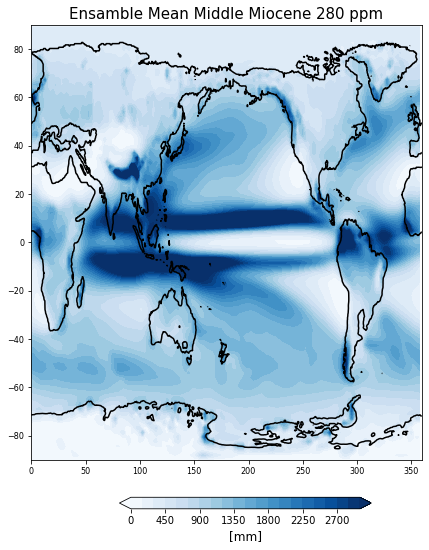

In [31]:
# Start plotting mean model output with proxies

contour_levels = np.linspace(0,3000,21)
contour_levels
norm = mcolors.BoundaryNorm(boundaries=contour_levels, ncolors=256)

fig = plt.figure(figsize=(12, 18), dpi=100) #figsize(weight,height)
fig,ax=plt.subplots(figsize=(7, 8))

cf = plt.contourf(prect280.lon,prect280.lat,prect280[0,:,:],contour_levels, cmap='Blues', extend="both")
ax.set_title("Ensamble Mean Middle Miocene 280 ppm", fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.contour(Herold_updated.topo.lon,Herold_updated.topo.lat,Herold_updated.topo, levels=[0], colors='k', linestyles='-')


# make an axes to put the shared colorbar in
colorbar_axes = plt.gcf().add_axes([0.3, 0.04, 0.5, 0.02])
colorbar = plt.colorbar(cf, colorbar_axes, orientation='horizontal')
colorbar.set_label('%s' % '[mm]',size=12)

